In [1]:
import numpy as np
import pandas as pd
import requests as req
import seaborn as sns

import matplotlib.pyplot as plt


Daily Acres: A measure of acres reported for a fire.  More specifically, the number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.  The minimum size must be 0.1.

Discovery Acres: An estimate of acres burning upon the discovery of the fire. More specifically when the fire is first reported by the first person that calls in the fire.  The estimate should include number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.

In [2]:
# load data
pd.options.display.max_columns = None
fires = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
fires = fires[['ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','POOState','PredominantFuelModel','FireCauseGeneral','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude']]
fires

/var/folders/qy/3rw6vnbs5j7dxjy7txkb9cgm0000gn/T/ipykernel_90769/859729889.py:3: DtypeWarning: Columns (13,32,61,64,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  fires = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")


,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude
0,2020/08/06 23:13:24+00,2020/08/06 23:13:07+00,2020/08/06 18:58:00+00,US-MT,GR4,Equipment,50.6,20.0,45.784960,-104.495800
1,NaN,NaN,2020/02/28 20:45:40+00,US-CA,NaN,NaN,NaN,0.1,33.808980,-118.180700
2,2017/10/18 00:35:00+00,2017/10/18 00:30:00+00,2017/10/17 20:20:24+00,US-MT,NaN,NaN,50.0,50.0,48.071670,-114.830300
3,NaN,NaN,2019/07/01 19:54:00+00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2016/06/20 22:05:59+00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
211532,NaN,NaN,2022/03/14 19:46:52+00,US-CA,NaN,NaN,NaN,0.1,38.404329,-120.454859
211533,NaN,NaN,2022/03/14 18:52:51+00,US-TX,NaN,Undetermined,10.0,30.0,31.189829,-97.951463
211534,NaN,2022/03/14 15:59:59+00,2022/03/13 20:15:00+00,US-OK,NaN,NaN,3.4,3.4,35.358830,-96.185750
211535,NaN,NaN,2022/03/14 19:39:15+00,US-TX,NaN,Undetermined,5.0,5.0,33.021967,-94.564750


In [3]:
# fillna with values from another column

fires['ControlDateTime'].fillna(fires['ContainmentDateTime'], inplace=True)
#fires['ControlDateTime'].fillna(fires['FireDiscoveryDateTime'], inplace=True)
fires['DiscoveryAcres'].fillna(fires['DiscoveryAcres'].mean(), inplace=True)
fires['DailyAcres'].fillna(0.1, inplace=True)
fires.isnull().sum()

ControlDateTime           81297
ContainmentDateTime       84264
FireDiscoveryDateTime         0
POOState                      0
PredominantFuelModel     178068
FireCauseGeneral         160734
DailyAcres                    0
DiscoveryAcres                0
InitialLatitude           59487
InitialLongitude          59487
dtype: int64

In [4]:
# check if there's any unformat datetime
fires['CorrectControlDateTime'] = pd.to_datetime(fires['ControlDateTime'],errors='coerce')
errors = fires.loc[fires['CorrectControlDateTime'].isnull()]['ControlDateTime'].unique().tolist()
errors

[nan,
 '0214/08/14 21:34:00+00',
 '0214/08/05 07:00:00+00',
 '1159/10/22 17:00:00+00']

In [5]:
correct_dict = {'0214/08/14 21:34:00+00' : '2014/08/14 21:34:00+00',
                '0214/08/05 07:00:00+00' : '2014/08/05 07:00:00+00',
                '1159/10/22 17:00:00+00' : '2014/08/03 17:00:00+00'}
fires['ControlDateTime'] = fires['CorrectControlDateTime'].fillna(pd.to_datetime(fires['ControlDateTime'].map(correct_dict)))


In [6]:
#convert DATETIME columns to datetime formula
fires['YEAR'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.year
fires['DiscoveryDate'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.date
fires['FireDiscoveryDateTime']=pd.to_datetime(fires['FireDiscoveryDateTime'], format="%Y-%m-%d %H:%M:%S")
fires['ControlDateTime']=pd.to_datetime(fires['ControlDateTime'], format="%Y-%m-%d %H:%M:%S")
fires.head()

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,Equipment,50.6,20.000000,45.78496,-104.4958,2020-08-06 23:13:24+00:00,2020,2020-08-06
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,NaN,NaN,0.1,0.100000,33.80898,-118.1807,NaT,2020,2020-02-28
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,NaN,NaN,50.0,50.000000,48.07167,-114.8303,2017-10-18 00:35:00+00:00,2017,2017-10-17
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,NaN,NaN,0.1,21.396285,NaN,NaN,NaT,2019,2019-07-01
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,NaN,NaN,0.1,21.396285,NaN,NaN,NaT,2016,2016-06-20


In [7]:
#add a column to calculate how long the fire was burning
fires["Fire_Duration"]=(fires['ControlDateTime'] - fires['FireDiscoveryDateTime'])/pd.Timedelta(hours=1)
fires

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate,Fire_Duration
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,Equipment,50.6,20.000000,45.784960,-104.495800,2020-08-06 23:13:24+00:00,2020,2020-08-06,4.256667
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,NaN,NaN,0.1,0.100000,33.808980,-118.180700,NaT,2020,2020-02-28,NaN
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,NaN,NaN,50.0,50.000000,48.071670,-114.830300,2017-10-18 00:35:00+00:00,2017,2017-10-17,4.243333
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,NaN,NaN,0.1,21.396285,NaN,NaN,NaT,2019,2019-07-01,NaN
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,NaN,NaN,0.1,21.396285,NaN,NaN,NaT,2016,2016-06-20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211532,NaT,NaN,2022-03-14 19:46:52+00:00,US-CA,NaN,NaN,0.1,0.100000,38.404329,-120.454859,NaT,2022,2022-03-14,NaN
211533,NaT,NaN,2022-03-14 18:52:51+00:00,US-TX,NaN,Undetermined,10.0,30.000000,31.189829,-97.951463,NaT,2022,2022-03-14,NaN
211534,2022-03-14 15:59:59+00:00,2022/03/14 15:59:59+00,2022-03-13 20:15:00+00:00,US-OK,NaN,NaN,3.4,3.400000,35.358830,-96.185750,2022-03-14 15:59:59+00:00,2022,2022-03-13,19.749722
211535,NaT,NaN,2022-03-14 19:39:15+00:00,US-TX,NaN,Undetermined,5.0,5.000000,33.021967,-94.564750,NaT,2022,2022-03-14,NaN


array([[<AxesSubplot:title={'center':'ControlDateTime'}>,
        <AxesSubplot:title={'center':'FireDiscoveryDateTime'}>,
        <AxesSubplot:title={'center':'DailyAcres'}>],
       [<AxesSubplot:title={'center':'DiscoveryAcres'}>,
        <AxesSubplot:title={'center':'InitialLatitude'}>,
        <AxesSubplot:title={'center':'InitialLongitude'}>],
       [<AxesSubplot:title={'center':'CorrectControlDateTime'}>,
        <AxesSubplot:title={'center':'YEAR'}>,
        <AxesSubplot:title={'center':'Fire_Duration'}>]], dtype=object)

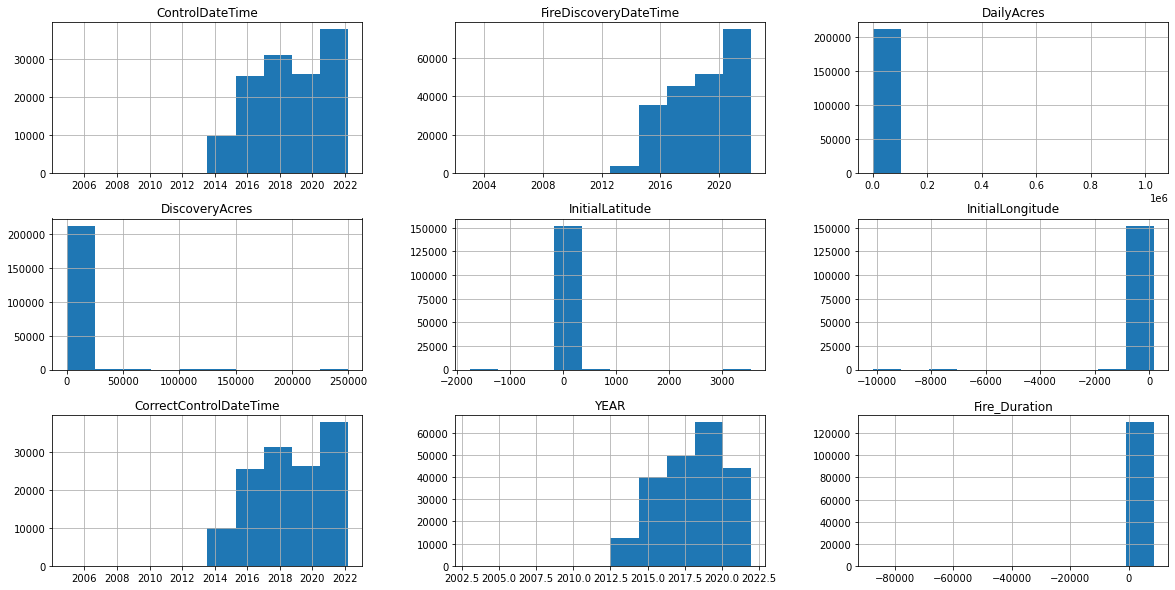

In [8]:
# Histogram for all features

fires.hist(figsize=[20,10])

In [9]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires.loc[fires['DiscoveryAcres'] <= .25, 'fire_severity1'] = 1
fires.loc[(fires['DiscoveryAcres'] > .25) & (fires['DiscoveryAcres'] <= 10), 'fire_severity1'] = 2
fires.loc[(fires['DiscoveryAcres'] > 10) & (fires['DiscoveryAcres'] <= 100), 'fire_severity1'] = 3
fires.loc[(fires['DiscoveryAcres'] > 100) & (fires['DiscoveryAcres'] <= 300), 'fire_severity1'] = 4
fires.loc[(fires['DiscoveryAcres'] > 300) & (fires['DiscoveryAcres'] <= 1000), 'fire_severity1'] = 5
fires.loc[(fires['DiscoveryAcres'] > 1000) & (fires['DiscoveryAcres'] <= 5000), 'fire_severity1'] = 6
fires.loc[fires['DiscoveryAcres'] > 500, 'fire_severity1'] = 7          
print(fires['fire_severity1'].value_counts())

1.0    97131
3.0    66427
2.0    45336
4.0     1282
7.0      884
5.0      477
Name: fire_severity1, dtype: int64


In [10]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires.loc[fires['DailyAcres'] <= .25, 'fire_severity2'] = 1
fires.loc[(fires['DailyAcres'] > .25) & (fires['DailyAcres'] <= 10), 'fire_severity2'] = 2
fires.loc[(fires['DailyAcres'] > 10) & (fires['DailyAcres'] <= 100), 'fire_severity2'] = 3
fires.loc[(fires['DailyAcres'] > 100) & (fires['DailyAcres'] <= 300), 'fire_severity2'] = 4
fires.loc[(fires['DailyAcres'] > 300) & (fires['DailyAcres'] <= 1000), 'fire_severity2'] = 5
fires.loc[(fires['DailyAcres'] > 1000) & (fires['DailyAcres'] <= 5000), 'fire_severity2'] = 6
fires.loc[fires['DailyAcres'] > 500, 'fire_severity2'] = 7          
print(fires['fire_severity2'].value_counts())

1.0    135128
2.0     46174
3.0     14145
7.0      7800
4.0      5918
5.0      2372
Name: fire_severity2, dtype: int64


In [11]:
fires.FireCauseGeneral.unique()

array(['Equipment', nan, 'Incendiary', 'Lightning', 'Debris/Open Burning',
       'Camping', 'Investigated but Undetermined', 'Other Human Cause',
       'Misc/Other', 'Cause and Origin Not Identified',
       'Firearms/Weapons', 'Other Natural Cause', 'Natural', 'Utilities',
       'Smoking', 'Debris Burning (Fire Use)', 'Coal Seam', 'Railroad',
       'Undetermined'], dtype=object)

In [12]:
# General Fire Cause to numerica values
fires['FireCauseGeneral'] = fires['FireCauseGeneral'].replace(['Incendiary','Other Human Cause','Debris/Open Burning','Equipment','Camping','Utilities','Firearms/Weapons','Investigated but Undetermined',
                                                               'Cause and Origin Not Identified','Coal Seam','Railroad','Smoking','Debris Burning (Fire Use)'],'1')
fires['FireCauseGeneral'] = fires['FireCauseGeneral'].replace(['Lightning','Other Natural Cause', 'Natural'],'2')
fires['FireCauseGeneral'] = fires['FireCauseGeneral'].replace(['Undetermined','Misc/Other', 'nan'],'3')

# Legend For General Cause
# 1 = Human
# 2 = Nature
# 3 = Uncategorized


In [13]:
# Import LE to convert Fuel Model and General Cause to Numeric Values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Converting Fuel Model to Numeric and using Label encoders for this 
label_encoder = LabelEncoder()
fires["fueltype_num"] = label_encoder.fit_transform(fires["PredominantFuelModel"])

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [15]:
fires_binary_encoded = pd.get_dummies(fires, columns=["PredominantFuelModel", "FireCauseGeneral"])
fires_binary_encoded.head()

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate,Fire_Duration,fire_severity1,fire_severity2,fueltype_num,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,PredominantFuelModel_GS2,PredominantFuelModel_GS3,PredominantFuelModel_GS4,PredominantFuelModel_NB1,PredominantFuelModel_NB9,PredominantFuelModel_SB1,PredominantFuelModel_SB2,PredominantFuelModel_SB3,PredominantFuelModel_SB4,PredominantFuelModel_SH1,PredominantFuelModel_SH2,PredominantFuelModel_SH3,PredominantFuelModel_SH4,PredominantFuelModel_SH5,PredominantFuelModel_SH6,PredominantFuelModel_SH7,PredominantFuelModel_SH8,PredominantFuelModel_SH9,PredominantFuelModel_TL1,PredominantFuelModel_TL2,PredominantFuelModel_TL3,PredominantFuelModel_TL4,PredominantFuelModel_TL5,PredominantFuelModel_TL6,PredominantFuelModel_TL7,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,50.6,20.000000,45.78496,-104.4958,2020-08-06 23:13:24+00:00,2020,2020-08-06,4.256667,3.0,3.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,0.1,0.100000,33.80898,-118.1807,NaT,2020,2020-02-28,NaN,1.0,1.0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,50.0,50.000000,48.07167,-114.8303,2017-10-18 00:35:00+00:00,2017,2017-10-17,4.243333,3.0,3.0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,0.1,21.396285,NaN,NaN,NaT,2019,2019-07-01,NaN,3.0,1.0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,0.1,21.396285,NaN,NaN,NaT,2016,2016-06-20,NaN,3.0,1.0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
fires_binary_encoded = fires_binary_encoded.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded.head()

,fire_severity1,fire_severity2,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,PredominantFuelModel_GS2,PredominantFuelModel_GS3,PredominantFuelModel_GS4,PredominantFuelModel_NB1,PredominantFuelModel_NB9,PredominantFuelModel_SB1,PredominantFuelModel_SB2,PredominantFuelModel_SB3,PredominantFuelModel_SB4,PredominantFuelModel_SH1,PredominantFuelModel_SH2,PredominantFuelModel_SH3,PredominantFuelModel_SH4,PredominantFuelModel_SH5,PredominantFuelModel_SH6,PredominantFuelModel_SH7,PredominantFuelModel_SH8,PredominantFuelModel_SH9,PredominantFuelModel_TL1,PredominantFuelModel_TL2,PredominantFuelModel_TL3,PredominantFuelModel_TL4,PredominantFuelModel_TL5,PredominantFuelModel_TL6,PredominantFuelModel_TL7,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Fire Severity base on Discovery Acres

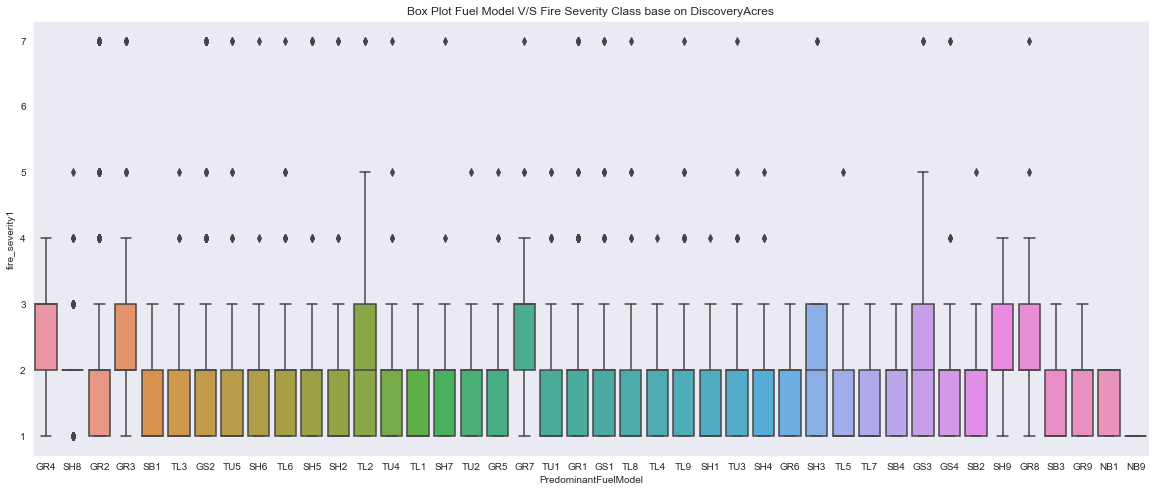

In [17]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity1', data=fires)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DiscoveryAcres')
plt.show()

In [18]:
# Define the features set.
X = fires_binary_encoded
X1 = X.drop(["fire_severity1","fire_severity2"], axis=1)
X1.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,PredominantFuelModel_GS2,PredominantFuelModel_GS3,PredominantFuelModel_GS4,PredominantFuelModel_NB1,PredominantFuelModel_NB9,PredominantFuelModel_SB1,PredominantFuelModel_SB2,PredominantFuelModel_SB3,PredominantFuelModel_SB4,PredominantFuelModel_SH1,PredominantFuelModel_SH2,PredominantFuelModel_SH3,PredominantFuelModel_SH4,PredominantFuelModel_SH5,PredominantFuelModel_SH6,PredominantFuelModel_SH7,PredominantFuelModel_SH8,PredominantFuelModel_SH9,PredominantFuelModel_TL1,PredominantFuelModel_TL2,PredominantFuelModel_TL3,PredominantFuelModel_TL4,PredominantFuelModel_TL5,PredominantFuelModel_TL6,PredominantFuelModel_TL7,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Define the target set.
y1 = fires_binary_encoded["fire_severity1"].ravel()
y1[:5]

array([3., 1., 3., 3., 3.])

In [20]:
# Splitting into Train and Test sets.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=78)

In [21]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X1_scaler = scaler.fit(X1_train)

# Scaling the data.
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [22]:
# Create a random forest classifier.
rf_model1 = RandomForestClassifier(n_estimators=100, random_state=78) 

In [23]:
# Fitting the model
rf_model1 = rf_model1.fit(X1_train_scaled, y1_train)

In [24]:
predictions1 = rf_model1.predict(X1_test_scaled)

In [25]:
predictions1

array([1., 1., 1., ..., 3., 3., 1.])

In [26]:
# Calculate feature importance in the Random Forest model.
importances1 = rf_model1.feature_importances_
importances1

array([0.04796305, 0.05835857, 0.00998946, 0.01735779, 0.00539918,
       0.00421309, 0.00156826, 0.00145646, 0.00127667, 0.03423027,
       0.07404312, 0.00632264, 0.00469304, 0.00042292, 0.        ,
       0.0207894 , 0.00614702, 0.0026059 , 0.00262315, 0.01205045,
       0.01693085, 0.0031463 , 0.0095295 , 0.01744431, 0.00480124,
       0.01273819, 0.00419222, 0.00175128, 0.0168688 , 0.00881668,
       0.02594941, 0.01107114, 0.01312759, 0.01935862, 0.00716343,
       0.03388907, 0.01799756, 0.04041637, 0.02037522, 0.00908126,
       0.00904368, 0.0378758 , 0.21725319, 0.0838334 , 0.04583447])

In [27]:
# Features Sorted by Importance
sorted(zip(rf_model1.feature_importances_, X1.columns), reverse=True)

[(0.21725319051357633, 'FireCauseGeneral_1'),
 (0.08383340361115019, 'FireCauseGeneral_2'),
 (0.07404311999092356, 'PredominantFuelModel_GS2'),
 (0.05835856725469618, 'PredominantFuelModel_GR2'),
 (0.047963049716384425, 'PredominantFuelModel_GR1'),
 (0.04583447173106756, 'FireCauseGeneral_3'),
 (0.040416374984746775, 'PredominantFuelModel_TU1'),
 (0.03787580015083376, 'PredominantFuelModel_TU5'),
 (0.03423026992799414, 'PredominantFuelModel_GS1'),
 (0.033889066858367206, 'PredominantFuelModel_TL8'),
 (0.025949413996778418, 'PredominantFuelModel_TL3'),
 (0.020789398023251988, 'PredominantFuelModel_SB1'),
 (0.020375219699673063, 'PredominantFuelModel_TU2'),
 (0.019358615889566024, 'PredominantFuelModel_TL6'),
 (0.01799755750284944, 'PredominantFuelModel_TL9'),
 (0.017444306338091808, 'PredominantFuelModel_SH5'),
 (0.0173577889481956, 'PredominantFuelModel_GR4'),
 (0.016930852129035823, 'PredominantFuelModel_SH2'),
 (0.016868803326876177, 'PredominantFuelModel_TL1'),
 (0.01312759225185549

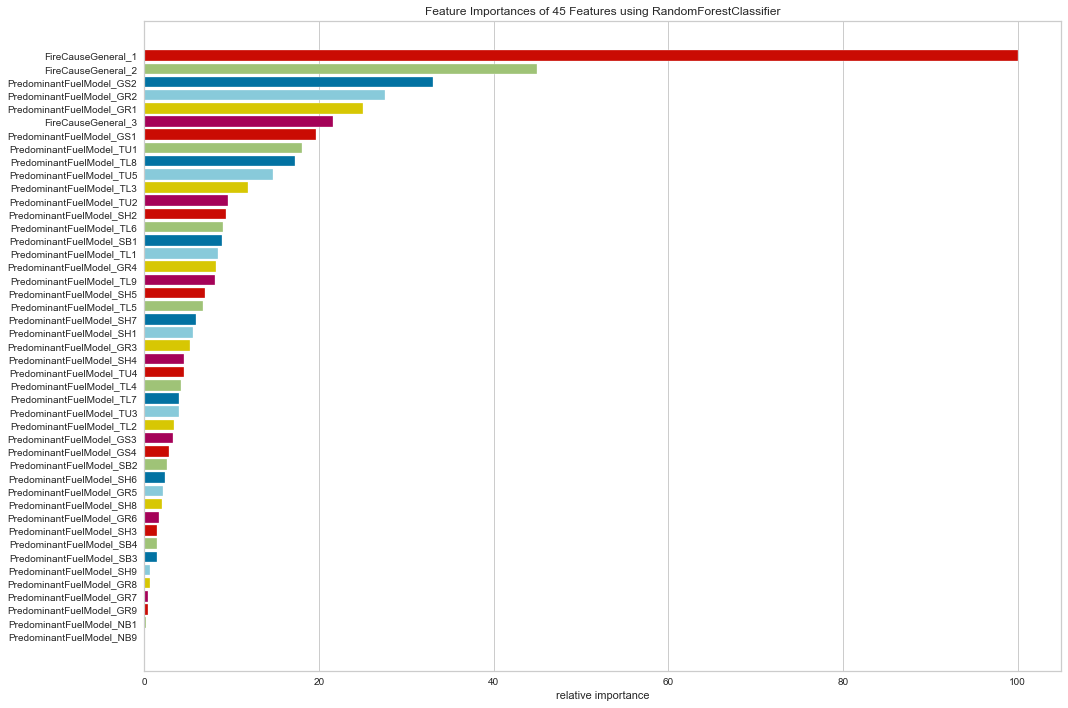

<AxesSubplot:title={'center':'Feature Importances of 45 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [28]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model1 = RandomForestClassifier(n_estimators=10)
viz1 = FeatureImportances(model1, size=(1080, 720))

viz1.fit(X1, y1)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz1.show()

In [29]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm1 = confusion_matrix(y1_test, predictions1)
# DataFrame from the confusion matrix.
cm_df1 = pd.DataFrame(cm1, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6"])
cm_df1

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Class 1,22096,1230,1077,0,0,1
Class 2,8435,1506,1205,1,0,1
Class 3,13441,493,2728,0,0,0
Class 4,250,26,53,0,0,0
Class 5,99,10,20,0,0,0
Class 6,176,12,25,0,0,0


In [30]:
# Calculating the accuracy score.
acc_score1 = accuracy_score(y1_test, predictions1)

In [31]:
# Displaying results
print("Confusion Matrix")
display(cm_df1)
print(f"Accuracy Score : {acc_score1}")
print("Classification Report")
print(classification_report(y1_test, predictions1))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Class 1,22096,1230,1077,0,0,1
Class 2,8435,1506,1205,1,0,1
Class 3,13441,493,2728,0,0,0
Class 4,250,26,53,0,0,0
Class 5,99,10,20,0,0,0
Class 6,176,12,25,0,0,0


Accuracy Score : 0.49787274274368915
Classification Report
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.64     24404
         2.0       0.46      0.14      0.21     11148
         3.0       0.53      0.16      0.25     16662
         4.0       0.00      0.00      0.00       329
         5.0       0.00      0.00      0.00       129
         7.0       0.00      0.00      0.00       213

    accuracy                           0.50     52885
   macro avg       0.25      0.20      0.18     52885
weighted avg       0.49      0.50      0.42     52885



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
from imblearn.combine import SMOTEENN

fires_smoteen = fires.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen.head()

,DailyAcres,DiscoveryAcres,YEAR,fire_severity1,fire_severity2,fueltype_num
0,50.6,20.000000,2020,3.0,3.0,3
1,0.1,0.100000,2020,1.0,1.0,42
2,50.0,50.000000,2017,3.0,3.0,42
3,0.1,21.396285,2019,3.0,1.0,42
4,0.1,21.396285,2016,3.0,1.0,42


In [33]:
x_cols1 = [i for i in fires_smoteen.columns if i not in ('fire_severity1')]
X1 = fires_smoteen[x_cols1]
y1 = fires_smoteen['fire_severity1']

In [34]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1, stratify=y1)

In [35]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X1_scaler = scaler.fit(X1_train)

# Scaling the data.
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [36]:
smoteenn = SMOTEENN(random_state=1)
X1_resampled, y1_resampled = smoteenn.fit_resample(X1_train_scaled, y1_train)
y1_resampled.value_counts()

7.0    72848
5.0    72793
4.0    72742
3.0    71874
1.0    71373
2.0    71057
Name: fire_severity1, dtype: int64

In [37]:
from sklearn.linear_model import LogisticRegression

smoteen_model1 = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model1.fit(X1_resampled, y1_resampled)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
from sklearn.metrics import confusion_matrix

y1_pred = smoteen_model1.predict(X1_test_scaled)
confusion_matrix(y1_test, y1_pred)

array([[20359,  3921,     3,     0,     0,     0],
       [ 1757,  9390,   187,     0,     0,     0],
       [    0,   686, 15414,   507,     0,     0],
       [    0,     0,     4,   317,     0,     0],
       [    0,     0,     0,     4,   115,     0],
       [    0,     0,     0,     0,     7,   214]])

In [39]:
from sklearn.metrics import balanced_accuracy_score

y1_pred = smoteen_model1.predict(X1_test_scaled)
balanced_accuracy_score(y1_test, y1_pred)

0.9195500427744571

In [40]:
# Display the confusion matrix
smoteen_cm1 = confusion_matrix(y1_test, y1_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df1 = pd.DataFrame(cm1, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6"], 
                             columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6"])
smoteen_cm_df1

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Class 1,22096,1230,1077,0,0,1
Class 2,8435,1506,1205,1,0,1
Class 3,13441,493,2728,0,0,0
Class 4,250,26,53,0,0,0
Class 5,99,10,20,0,0,0
Class 6,176,12,25,0,0,0


In [41]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y1_test, y1_pred))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.92      0.84      0.94      0.88      0.89      0.78     24283
        2.0       0.67      0.83      0.89      0.74      0.86      0.73     11334
        3.0       0.99      0.93      0.99      0.96      0.96      0.92     16607
        4.0       0.38      0.99      0.99      0.55      0.99      0.98       321
        5.0       0.94      0.97      1.00      0.95      0.98      0.96       119
        7.0       1.00      0.97      1.00      0.98      0.98      0.97       221

avg / total       0.89      0.87      0.95      0.87      0.91      0.81     52885



Fire Severity base on Daily Acres

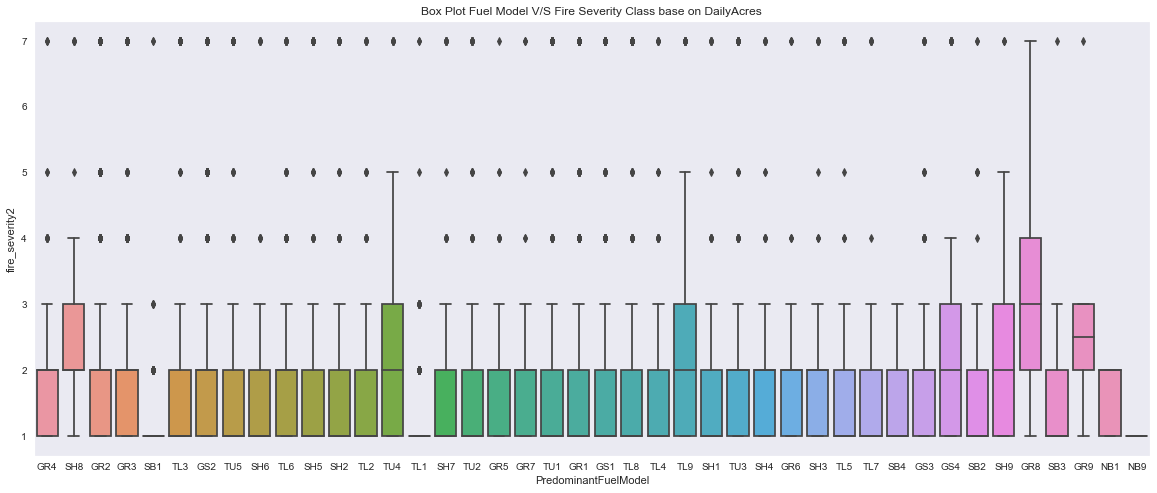

In [43]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity2', data=fires)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DailyAcres')
plt.show()

In [44]:
# Define the features set.
X2 = X.drop(["fire_severity1","fire_severity2"], axis=1)
X2.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,PredominantFuelModel_GS2,PredominantFuelModel_GS3,PredominantFuelModel_GS4,PredominantFuelModel_NB1,PredominantFuelModel_NB9,PredominantFuelModel_SB1,PredominantFuelModel_SB2,PredominantFuelModel_SB3,PredominantFuelModel_SB4,PredominantFuelModel_SH1,PredominantFuelModel_SH2,PredominantFuelModel_SH3,PredominantFuelModel_SH4,PredominantFuelModel_SH5,PredominantFuelModel_SH6,PredominantFuelModel_SH7,PredominantFuelModel_SH8,PredominantFuelModel_SH9,PredominantFuelModel_TL1,PredominantFuelModel_TL2,PredominantFuelModel_TL3,PredominantFuelModel_TL4,PredominantFuelModel_TL5,PredominantFuelModel_TL6,PredominantFuelModel_TL7,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# Define the target set.
y2 = fires_binary_encoded["fire_severity2"].ravel()
y2[:5]

array([3., 1., 3., 1., 1.])

In [46]:
# Splitting into Train and Test sets.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=78)

In [47]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X2_scaler = scaler.fit(X2_train)

# Scaling the data.
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [48]:
# Create a random forest classifier.
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=78) 

In [49]:
# Fitting the model
rf_model2 = rf_model2.fit(X2_train_scaled, y2_train)

In [50]:
predictions2 = rf_model2.predict(X2_test_scaled)
predictions2

array([1., 1., 1., ..., 1., 1., 1.])

In [51]:
# Calculate feature importance in the Random Forest model.
importances2 = rf_model2.feature_importances_
importances2

array([0.02181559, 0.07339736, 0.03047937, 0.01615382, 0.01249758,
       0.00826196, 0.00734208, 0.00523815, 0.00295912, 0.0103198 ,
       0.06040634, 0.00913739, 0.00677687, 0.00068907, 0.        ,
       0.04078821, 0.0056975 , 0.00218256, 0.00144124, 0.00514276,
       0.00572382, 0.00331421, 0.00641709, 0.01575616, 0.00307938,
       0.00737975, 0.01032199, 0.00426014, 0.02893529, 0.00871432,
       0.0173657 , 0.00351443, 0.01061952, 0.02776676, 0.00465207,
       0.01440066, 0.02845757, 0.02819433, 0.00470228, 0.00598355,
       0.01718474, 0.01323069, 0.31844451, 0.06325319, 0.0276011 ])

In [52]:
# Features Sorted by Importance
sorted(zip(rf_model2.feature_importances_, X2.columns), reverse=True)

[(0.3184445075595502, 'FireCauseGeneral_1'),
 (0.07339735992574266, 'PredominantFuelModel_GR2'),
 (0.0632531867449107, 'FireCauseGeneral_2'),
 (0.06040634439262889, 'PredominantFuelModel_GS2'),
 (0.040788208935985136, 'PredominantFuelModel_SB1'),
 (0.030479368908022823, 'PredominantFuelModel_GR3'),
 (0.028935289618986882, 'PredominantFuelModel_TL1'),
 (0.028457567479058674, 'PredominantFuelModel_TL9'),
 (0.02819432934464497, 'PredominantFuelModel_TU1'),
 (0.027766756754164103, 'PredominantFuelModel_TL6'),
 (0.027601100788536212, 'FireCauseGeneral_3'),
 (0.021815593258928758, 'PredominantFuelModel_GR1'),
 (0.017365696460492696, 'PredominantFuelModel_TL3'),
 (0.017184736553115983, 'PredominantFuelModel_TU4'),
 (0.01615382095637402, 'PredominantFuelModel_GR4'),
 (0.015756162938735656, 'PredominantFuelModel_SH5'),
 (0.0144006615375, 'PredominantFuelModel_TL8'),
 (0.013230691812867634, 'PredominantFuelModel_TU5'),
 (0.01249757939773343, 'PredominantFuelModel_GR5'),
 (0.01061951974793155, 'P

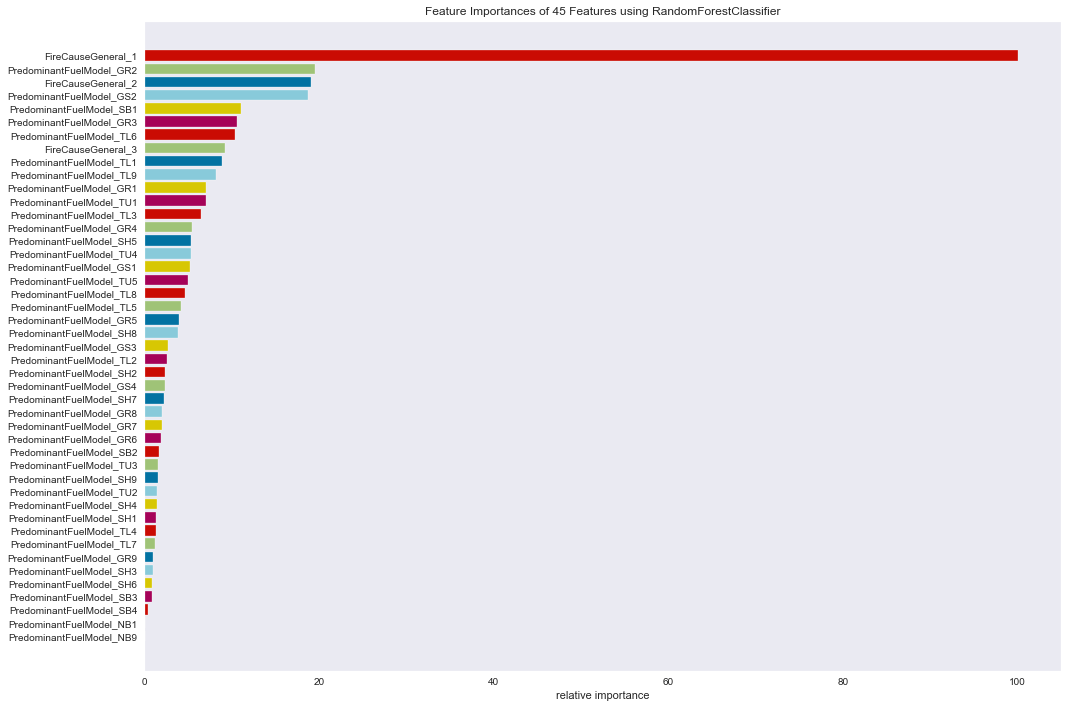

<AxesSubplot:title={'center':'Feature Importances of 45 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [53]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model2 = RandomForestClassifier(n_estimators=10)
viz2 = FeatureImportances(model2, size=(1080, 720))

viz2.fit(X2, y2)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz2.show()

In [54]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm2 = confusion_matrix(y2_test, predictions2)
# DataFrame from the confusion matrix.
cm_df2 = pd.DataFrame(cm2, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6"])
cm_df2

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Class 1,33628,219,6,1,0,2
Class 2,11201,210,14,0,1,5
Class 3,3475,93,19,0,0,4
Class 4,1443,27,3,0,0,1
Class 5,586,3,2,0,0,1
Class 6,1907,26,6,0,0,2


In [55]:
# Calculating the accuracy score.
acc_score2 = accuracy_score(y2_test, predictions2)

In [56]:
# Displaying results
print("Confusion Matrix")
display(cm_df2)
print(f"Accuracy Score : {acc_score2}")
print("Classification Report")
print(classification_report(y2_test, predictions2))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Class 1,33628,219,6,1,0,2
Class 2,11201,210,14,0,1,5
Class 3,3475,93,19,0,0,4
Class 4,1443,27,3,0,0,1
Class 5,586,3,2,0,0,1
Class 6,1907,26,6,0,0,2


Accuracy Score : 0.6402382528127069
Classification Report
              precision    recall  f1-score   support

         1.0       0.64      0.99      0.78     33856
         2.0       0.36      0.02      0.03     11431
         3.0       0.38      0.01      0.01      3591
         4.0       0.00      0.00      0.00      1474
         5.0       0.00      0.00      0.00       592
         7.0       0.13      0.00      0.00      1941

    accuracy                           0.64     52885
   macro avg       0.25      0.17      0.14     52885
weighted avg       0.52      0.64      0.51     52885



In [57]:
x_cols2 = [i for i in fires_smoteen.columns if i not in ('fire_severity2')]
X2 = fires_smoteen[x_cols2]
y2 = fires_smoteen['fire_severity2']

In [58]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1, stratify=y2)

In [59]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X2_scaler = scaler.fit(X2_train)

# Scaling the data.
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [60]:
X2_resampled, y2_resampled = smoteenn.fit_resample(X2_train_scaled, y2_train)
y2_resampled.value_counts()

7.0    101143
5.0    100944
1.0    100748
4.0    100557
3.0    100322
2.0    100267
Name: fire_severity2, dtype: int64

In [61]:
smoteen_model2 = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model2.fit(X2_resampled, y2_resampled)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [62]:
y2_pred = smoteen_model2.predict(X2_test_scaled)
confusion_matrix(y2_test, y2_pred)

array([[20610,  2025, 11146,     0,     0,     1],
       [ 2433,  6797,  2314,     0,     0,     0],
       [  698,  1182,  1500,   156,     0,     0],
       [   78,    39,     8,  1229,   126,     0],
       [    0,     0,     0,     2,   590,     1],
       [    0,     0,     0,     0,   195,  1755]])

In [63]:
y2_pred = smoteen_model2.predict(X2_test_scaled)
balanced_accuracy_score(y2_test, y2_pred)

0.7247389091212831

In [64]:
# Display the confusion matrix
smoteen_cm2 = confusion_matrix(y2_test, y2_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df2 = pd.DataFrame(cm2, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6"], 
                             columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6"])
smoteen_cm_df2

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Class 1,33628,219,6,1,0,2
Class 2,11201,210,14,0,1,5
Class 3,3475,93,19,0,0,4
Class 4,1443,27,3,0,0,1
Class 5,586,3,2,0,0,1
Class 6,1907,26,6,0,0,2


In [65]:
print(classification_report_imbalanced(y2_test, y2_pred))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.87      0.61      0.83      0.72      0.71      0.50     33782
        2.0       0.68      0.59      0.92      0.63      0.74      0.52     11544
        3.0       0.10      0.42      0.73      0.16      0.56      0.30      3536
        4.0       0.89      0.83      1.00      0.86      0.91      0.81      1480
        5.0       0.65      0.99      0.99      0.78      0.99      0.99       593
        7.0       1.00      0.90      1.00      0.95      0.95      0.89      1950

avg / total       0.78      0.61      0.86      0.67      0.72      0.52     52885

